PREDICTING WITH WAVELET SCATTERING

---




### 1. Google Colab runtime setup [Optional]

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
# Clone and install spectrai package 
!git clone https://github.com/franckalbinet/spectrai.git 
!pip install /content/spectrai 

In [ ]:
# Prepare /root folder content
!cp -r /content/drive/My\ Drive/Colab\ Notebooks/data/data_spectrai /root

In [ ]:
# Create configuration file
!mkdir /root/.spectrai_config & cp /content/spectrai/config.toml /root/.spectrai_config

### 2. Import packages

In [ ]:
# To train on a GPU
!pip install tensorflow-gpu

In [ ]:
from spectrai.datasets.kssl import (get_tax_orders_lookup_tbl, load_data)
from spectrai.vis.spectra import (plot_spectra)
from spectrai.metrics.keras import rpd

from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.cross_decomposition import PLSRegression

from scipy.signal import savgol_filter
import numpy as np

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.optimizers import RMSprop
from tensorflow.keras import layers, models, Model
import tensorflow.keras.backend as K
import tensorflow.keras.utils as utils

from kymatio.numpy import Scattering1D as np_Scattering1D
from kymatio.keras import Scattering1D, Scattering2D

import matplotlib.pyplot as plt

### 3. Load KSSL dataset

In [ ]:
# Loading Potassium, NH4OAc
X, X_names, y, y_names, instances_id = load_data([725])

In [ ]:
print('X shape: ', X.shape)
print('X approx. memory size: {} MB'.format(X.nbytes // 10**6))
print('y approx. memory size: {} MB'.format(y.nbytes // 10**6))
print('Wavenumbers: ', X_names)
print('Target variable: ', y_names)

X shape:  (50714, 1764)
X approx. memory size: 357 MB
y approx. memory size: 1 MB
Wavenumbers:  [3999 3997 3995 ...  603  601  599]
Target variable:  ['lay_depth_to_top' 'order_id' 'calc_value']


### 4. Data preparation

In [ ]:
# Keeping data with analyte concentration > 0 only
idx_y_valid = y[:, -1] > 0
X = X[idx_y_valid,:]
y = y[idx_y_valid,:]

# Note that we do not apply Savitsky-Golay derivation/filtering as it
# is assumed that such feature engineering is performed automaticlly by a CNN. 

# Scale data
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

In [ ]:
# Creating train, valid, test sets
X, X_test, y, y_test = train_test_split(X, y[:, -1], test_size=0.20, random_state=42)
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.20, random_state=42)

print('X test shape: ', X_test.shape)
print('X valid shape: ', X_valid.shape)
print('X train shape: ', X_train.shape)
print('y train shape: ', y_train.shape)

X test shape:  (9728, 1764)
X valid shape:  (7782, 1764)
X train shape:  (31126, 1764)
y train shape:  (31126,)


### 5. Defining Scattering and model

In [ ]:
# What are the shapes of order 0, 1 and 2
J = 4
T = X_train.shape[1]
Q = 12

scattering = np_Scattering1D(J, T, Q)
Sx = scattering(X_train[0,:])

meta = scattering.meta()
order0 = np.where(meta['order'] == 0)
order1 = np.where(meta['order'] == 1)
order2 = np.where(meta['order'] == 2)
print(Sx[order0][0].shape)
print(Sx[order1].shape)
print(Sx[order2].shape)

(111,)
(28, 111)
(36, 111)


In [ ]:
# Set the parameters of the scattering transform.
J = 4
T = X_train.shape[1]
Q = 12

x = X_train[0,:]

# Define a Scattering1D object.
S = Scattering1D(J, Q)

# Calculate the scattering transform.
Sx = S(x)

In [ ]:
Sx.shape

TensorShape([65, 111])

In [ ]:
Sx[1:,:].shape

TensorShape([64, 111])

In [ ]:
activation = 'relu'
input_dim = X_train.shape[1]
J = 4
Q = 12
#model = keras.models.Sequential()
#x = layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

inputs = layers.Input(shape=input_dim)
x = Scattering1D(J=J, Q=Q)(inputs)
print(x.shape)
x = layers.Lambda(lambda x: K.gather(x, range(1, 29)))(x)
print(k.int_shape(x)
x = layers.Lambda(lambda x: K.expand_dims(x, -1))(x)
#x = layers.Reshape(x.shape[1:], input_shape=x.shape)(x)
print(x.shape)

(None, 65, 111)
(28, 65, 111)
(28, 65, 111, 1)


In [ ]:
activation = 'relu'
input_dim = X_train.shape[1]

inputs = layers.Input(shape=input_dim)

x = Scattering1D(J=J, Q=Q, max_order=2)(inputs)
x = layers.Lambda(lambda x: K.expand_dims(x, -1))(x)
x = layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)


#x = layers.BatchNormalization()(x)
x = layers.Lambda(lambda x: K.squeeze(x, axis=-1))(x)
x = Scattering2D(J=3, max_order=2)(x)


#x = layers.BatchNormalization()(x)
x = layers.Flatten()(x)
#x = layers.Dense(100, activation=activation)(x)
x = layers.Dense(20, activation=activation)(x)
x_out = layers.Dense(1, activation='linear')(x)
model = Model(inputs, x_out)

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse', metrics=[rpd])
model.summary()

Model: "model_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_47 (InputLayer)        [(None, 1764)]            0         
_________________________________________________________________
scattering1d_46 (Scattering1 (None, 65, 111)           0         
_________________________________________________________________
lambda_52 (Lambda)           (None, 65, 111, 1)        0         
_________________________________________________________________
cropping2d_27 (Cropping2D)   (None, 64, 111, 1)        0         
_________________________________________________________________
lambda_53 (Lambda)           (None, 64, 111)           0         
_________________________________________________________________
scattering2d_12 (Scattering2 (None, 217, 8, 13)        0         
_________________________________________________________________
flatten_14 (Flatten)         (None, 22568)             0  

In [ ]:
activation = 'relu'
input_dim = X_train.shape[1]

#model = keras.models.Sequential()
#x = layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

inputs = layers.Input(shape=input_dim)
x = Scattering1D(J=J, Q=Q)(inputs)

x = layers.Lambda(lambda x: K.expand_dims(x, -1))(x)

x = layers.Cropping2D(cropping=((1, 0), (0, 0)))(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(16, (4, 4), activation=activation)(x)
x = layers.MaxPool2D(4, 4)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (4, 4), activation=activation)(x)
x = layers.MaxPool2D(4, 4)(x)

x = layers.Flatten()(x)
#x = layers.Dense(20, activation=activation)(x)
x_out = layers.Dense(1, activation='linear')(x)
model = Model(inputs, x_out)

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse', metrics=[rpd])
model.summary()

Model: "model_19"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_52 (InputLayer)        [(None, 1764)]            0         
_________________________________________________________________
scattering1d_51 (Scattering1 (None, 65, 111)           0         
_________________________________________________________________
lambda_58 (Lambda)           (None, 65, 111, 1)        0         
_________________________________________________________________
cropping2d_32 (Cropping2D)   (None, 64, 111, 1)        0         
_________________________________________________________________
batch_normalization_30 (Batc (None, 64, 111, 1)        4         
_________________________________________________________________
conv2d_23 (Conv2D)           (None, 61, 108, 16)       272       
_________________________________________________________________
max_pooling2d_21 (MaxPooling (None, 15, 27, 16)        0  

### 6. Training the model

In [ ]:
#reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=1e-4)
history = model.fit(X_train, y_train, epochs=200, validation_data=(X_valid, y_valid))

Epoch 1/200
973/973 [==============================] - 47s 48ms/step - loss: 0.9850 - rpd: 1.0429 - val_loss: 1.0511 - val_rpd: 1.0707
Epoch 2/200
973/973 [==============================] - 45s 46ms/step - loss: 0.9149 - rpd: 1.0821 - val_loss: 1.0072 - val_rpd: 1.0955
Epoch 3/200
973/973 [==============================] - 45s 46ms/step - loss: 0.8779 - rpd: 1.1114 - val_loss: 0.9883 - val_rpd: 1.1287
Epoch 4/200
973/973 [==============================] - 45s 46ms/step - loss: 0.8483 - rpd: 1.1355 - val_loss: 0.9505 - val_rpd: 1.1376
Epoch 5/200
973/973 [==============================] - 45s 46ms/step - loss: 0.8237 - rpd: 1.1540 - val_loss: 0.9299 - val_rpd: 1.1567
Epoch 6/200
973/973 [==============================] - 45s 46ms/step - loss: 0.8030 - rpd: 1.1679 - val_loss: 0.9224 - val_rpd: 1.1777
Epoch 7/200
973/973 [==============================] - 45s 46ms/step - loss: 0.7845 - rpd: 1.1797 - val_loss: 0.9041 - val_rpd: 1.1892
Epoch 8/200
973/973 [==============================] - 

### 7. Assessing learning

In [ ]:
# Concat all runs history
def concat_history(*args):
  all_history = args[0].history.copy()
  for hist in args[1:]:
    for k in all_history.keys():
      all_history[k] += hist.history[k]
  return all_history

all_history = concat_history(history)

NameError: ignored

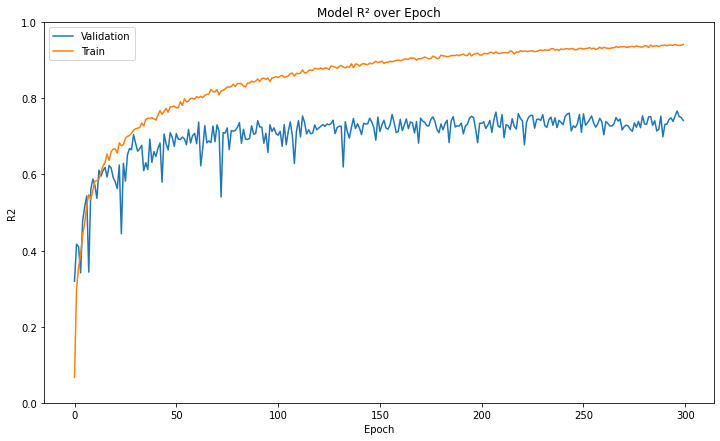

In [ ]:
# Plot training & validation accuracy values
fig, ax = plt.subplots(figsize=(12,7))
_ = ax.plot(all_history['val_coeff_determination'])
_ = ax.plot(all_history['coeff_determination'])
plt.ylim(0, 1)
plt.title('Model R² over Epoch')
plt.ylabel('R2')
plt.xlabel('Epoch')
plt.legend(['Validation', 'Train'], loc='upper left')

### Multi-channel wavelet scattering CNN

In [ ]:
activation = 'relu'
input_dim = X_train.shape[1]

#model = keras.models.Sequential()
#x = layers.Reshape((input_dim, 1), input_shape=(input_dim,)))

inputs = layers.Input(shape=input_dim)
x = Scattering1D(J=J, Q=Q)(inputs)

x = layers.Lambda(lambda x: K.expand_dims(x, -1))(x)

x_first_order = layers.Cropping2D(cropping=((1, 36), (0, 0)))(x)

x_second_order = layers.Cropping2D(cropping=((1, 36), (0, 0)))(x)


x = layers.BatchNormalization()(x)
x = layers.Conv2D(32, (3, 3), activation=activation)(x)
x = layers.MaxPool2D(2, 2)(x)

x = layers.BatchNormalization()(x)
x = layers.Conv2D(64, (3, 3), activation=activation)(x)
x = layers.MaxPool2D(2, 2)(x)

x = layers.Flatten()(x)
x = layers.Dense(50, activation=activation)(x)
x_out = layers.Dense(1, activation='linear')(x)
model = Model(inputs, x_out)

model.compile(optimizer=RMSprop(learning_rate=1e-4), loss='mse', metrics=[rpd])
model.summary()